In [1]:
import kaleido
import pandas as pd
import numpy as np
import plotly.graph_objects as go
######## Search space #########
import sys
sys.path.append("../")
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results
# Initialize an empty list to store dictionaries
def results_to_df(path, name):
    data = []
    # Open the text file
    with open(path, 'r') as file:
        lines = file.readlines()
        # Initialize an empty dictionary to store data for each block
        block_data = {}
        for line in lines:
            # If the line contains dashes, it indicates the end of a block
            if '-------------------------' in line:
                # If block_data is not empty, add it to the list of data dictionaries
                if block_data:
                    data.append(block_data)
                    # Reset block_data for the next block
                    block_data = {}
            elif 'best_acc' in line:
                continue
            else:
                # Split the line by ':'
                #print(line)
                key, value = line.strip().split(': ')
                # Store the key-value pair in the block_data dictionary
                block_data[key] = value

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    # Convert columns to appropriate data types if needed
    df['epoch'] = df['epoch'].astype(int)
    df['lr'] = df['lr'].astype(float)
    df['train_acc'] = df['train_acc'].astype(float)
    df['train_loss'] = df['train_loss'].astype(float)
    df['test_acc'] = df['test_acc'].astype(float)
    df['test_acc_top5'] = df['test_acc_top5'].astype(float)
    df['test_loss'] = df['test_loss'].astype(float)
    df['epoch_time'] = df['epoch_time'].astype(float)
    df=df.assign(name=name)
    
    return df

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import os

metadata_dict={}
metadata_dict["Caitie"]={'num_classes': 4,
                         'input_shape': [49260, 3, 64, 64],
                         'codename': 'Caitie',
                         'benchmark': 47.008,
                         }
metadata_dict["Adaline"]={'num_classes': 20,
                         'input_shape': [50000, 3, 28, 28],
                         'codename': 'Adaline',
                         'benchmark': 89.85}
metadata_dict["Chester"]={'input_shape': [49998, 12, 8, 8],
                         'codename': 'Chester',
                         'benchmark': 57.826,
                         'num_classes': 3}
metadata_dict["Gutenberg"]={'input_shape': [45000, 1, 27, 18],
                         'codename': 'Gutenberg',
                         'benchmark': 40.98,
                         'num_classes': 6}
metadata_dict["LaMelo"]={'num_classes': 10,
                         'codename': 'LaMelo',
                         'input_shape': [50000, 1, 24, 24],
                         'benchmark': 85.2}
metadata_dict["Mateo"]={'num_classes': 10,
                         'input_shape': [50000, 3, 28, 28],
                         'codename': 'Mateo',
                         'benchmark': 90.87}
metadata_dict["Sadie"]={'input_shape': [50000, 3, 64, 64],
                         'codename': 'Sadie',
                         'benchmark': 80.33,
                         'num_classes': 10}
metadata_dict["Sokoto"]={'input_shape': [50000, 1, 9, 9],
                         'codename': 'Sokoto',
                         'benchmark': 0.0,
                         'num_classes': 9}
def get_predictor_data_from_folder(base_folder,studies):

    
    train_data=[]
    for study_name in studies: 
        

        metadata=metadata_dict[study_name]
        rg=RegNet(metadata,
                        W0=[16, 120, 8],
                        WA=[16, 64, 8],
                        WM=[2.05,2.9,0.05],
                        D=[8,22,1], 
                        G=[8,8,8], 
                        base_config=f"../configs/search_space/config.yaml")
        data=[]
        study_folder=f"{base_folder}/{study_name}"
        subjects= os.listdir(study_folder)

        subjects=[subject for subject in subjects if os.path.isdir(f"{study_folder}/{subject}")]
        print(subjects)
        for name in subjects:
            try:
                test_acc=results_to_df(f"{study_folder}/{name}/worklog.txt", f"{name}")[["epoch","test_acc","name"]]
                #test_acc=test_acc.rename(columns={"test_acc":"acc","test_loss":"test_acc"})
                #print(test_acc.columns)
                if len(test_acc)>49:
                    test_acc_piv = test_acc[["epoch","test_acc","name"]].pivot(index='name', columns='epoch', values='test_acc').add_prefix("epoch_").reset_index()
                    test_acc_piv["best_acc"]=test_acc["test_acc"].max()
                    
                    model, info=rg.load_model(config_file=f"{study_folder}/{name}/config.yaml")
                    test_acc_piv["gen"]=1
                    test_acc_piv["num_stages"]=info["num_stages"]
                    test_acc_piv["params"]=info["params"]
                    test_acc_piv["WA"]=info["WA"]
                    test_acc_piv["W0"]=info["W0"]
                    test_acc_piv["WM"]=info["WM"]
                    test_acc_piv["DEPTH"]=info["DEPTH"]
                    test_acc_piv["num_classes"]=metadata["num_classes"]
                    test_acc_piv["num_channels"]=metadata["input_shape"][1]
                    test_acc_piv["benchmark"]=metadata["benchmark"]
                    test_acc_piv["codename"]=study_name
                    
                    #print(info)
                    data.append(test_acc_piv)
            except:
                    pass

        data=pd.concat(data)
        train_data.append(data)
    train_data=pd.concat(train_data)
    return train_data
    

In [3]:
test_dataset="Caitie"
add_zcost_features=False
corr_scores={}
accuracies={}
test_accuracies={}
epochs_results={}

In [4]:
studies=["LaMelo","Caitie", "Adaline","Gutenberg","Sadie", "Chester", "Mateo"]
train_studies=[dataset for dataset in studies if dataset!=test_dataset]
test_studies=[test_dataset]

In [5]:
train_data=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train",
                                          studies=train_studies)
test_data=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train",
                                         studies=test_studies)

['dangerous_degu', 'didactic_armadillo', 'tiny_sturgeon', 'jolly_buzzard', 'great_prawn', 'illustrious_trout', 'notorious_sawfly', 'merry_lizard', 'outstanding_mantis', 'fluffy_boa', 'logical_hornet', 'great_coyote', 'discerning_beluga', 'monumental_galago', 'colossal_hedgehog', 'fragrant_skylark', 'vivid_owl', 'wandering_silkworm', 'jasmine_dugong', 'ultramarine_caiman', 'astute_barracuda', 'silver_ammonite', 'foamy_rat', 'camouflaged_kittiwake', 'quick_prawn', 'angelic_coati', 'tested_nuthatch', 'prompt_dog', 'organic_lorikeet', 'convivial_jellyfish', 'enlightened_impala', 'scarlet_grasshopper', 'jade_baboon', 'adaptable_jacamar', 'real_caterpillar', 'poised_frog', 'cornflower_salamander', 'curious_viper', 'elated_pig', 'gleaming_hawk', 'fluorescent_antelope', 'antique_anteater', 'inventive_jellyfish', 'curly_emu', 'auburn_sturgeon', 'fat_parakeet', 'unique_grasshopper', 'demonic_hornet', 'crafty_hyrax', 'orange_ara', 'thundering_seahorse', 'lime_hyena', 'vanilla_ara', 'peculiar_dorm

In [6]:
if add_zcost_features:
    dfs_zcost=[]
    for codename in studies:
        df_zcost=pd.read_csv(f"zcost_proxies/results/{codename}_clf_train.csv", index_col=0)
        df_zcost["codename"]=codename
        dfs_zcost.append(df_zcost)

    dfs_zcost=pd.concat(dfs_zcost)
    train_data=pd.merge(train_data, dfs_zcost, on=["name","codename"])
    test_data=pd.merge(test_data, dfs_zcost, on=["name","codename"])

In [7]:
train_data_2=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/stages_pool",
                                          studies=train_studies)
test_data_2=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/stages_pool",
                                         studies=test_studies)

['porcelain_anteater', 'lilac_dingo', 'unique_cockatoo', 'aloof_crow', 'mysterious_wombat', 'furry_binturong', 'loyal_sheep', 'muscular_stork', 'outgoing_goose', 'colorful_vulture', 'sceptical_foxhound', 'alluring_gibbon', 'banana_bee', 'crafty_jellyfish', 'truthful_cuscus', 'asparagus_kangaroo', 'chocolate_silkworm', 'enlightened_cuscus', 'cooperative_teal', 'devout_panda', 'hallowed_pug', 'elated_lionfish', 'nano_dinosaur', 'perky_bulldog', 'wondrous_crayfish', 'precise_rottweiler', 'funky_sponge', 'phenomenal_sidewinder', 'amiable_cow', 'powerful_locust', 'delectable_fennec', 'gray_tarsier', 'romantic_adder', 'heretic_nyala', 'observant_ringtail', 'ultramarine_iguana', 'mutant_sambar', 'ultraviolet_rattlesnake', 'devout_dingo', 'ancient_poodle', 'curvy_jaguarundi', 'rainbow_manatee', 'ochre_cat', 'tangerine_crayfish', 'arboreal_kudu', 'attentive_agouti', 'zippy_mastodon', 'literate_magpie', 'meticulous_gerbil', 'fresh_ibis', 'rose_smilodon', 'imaginary_tiger', 'magnificent_impala', 

In [8]:
if add_zcost_features:
    dfs_zcost=[]
    for codename in studies:
        df_zcost=pd.read_csv(f"zcost_proxies/results/{codename}.csv", index_col=0)
        df_zcost["codename"]=codename
        dfs_zcost.append(df_zcost)

    dfs_zcost=pd.concat(dfs_zcost)
    train_data_2=pd.merge(train_data_2, dfs_zcost, on=["name","codename"])
    test_data_2=pd.merge(test_data_2, dfs_zcost, on=["name","codename"])

In [9]:
train_data= pd.concat([train_data,train_data_2]).drop(columns=["epoch_0", "codename"])
test_data=pd.concat([test_data,test_data_2]).drop(columns=["epoch_0", "codename"])

In [10]:
zcost_metrics=["fisher","grad_norm","jacob_cov","plain","snip","synflow", "grasp"]
#zcost_metrics=["jacob_cov"]

In [11]:
# Standardize data
standardize=True
from sklearn.preprocessing import StandardScaler
if standardize:
    def standard_scaler(group):
        scaler = StandardScaler()
        #cols=list(group.columns[1:])
        #cols=["num_stages","params","WA","W0","WM","DEPTH"]
        cols=["params","WA","W0","WM","DEPTH","best_acc"] 
        if add_zcost_features:
            cols=cols+zcost_metrics
        #cols=["best_acc", "synflow"] 
        #cols=["best_acc", "synflow"] 
        #cols=[ "synflow"] 
        #cols=["grasp"]
        #cols.remove("best_acc")
        #cols.remove("benchmark")
        #cols.remove("gen")
        group[cols] = scaler.fit_transform(group[cols])

        return group
    train_data = train_data.groupby('benchmark').apply(standard_scaler)
    train_data=train_data.reset_index(drop=True)

    test_data = test_data.groupby('benchmark').apply(standard_scaler)
    test_data=test_data.reset_index(drop=True)

/tmp/ipykernel_3795318/3353215657.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = train_data.groupby('benchmark').apply(standard_scaler)
/tmp/ipykernel_3795318/3353215657.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = test_data.groupby('benchmark').apply(standard_scaler)


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

from scipy.stats import spearmanr
from scipy.stats import kendalltau

def kendall_tau_distance(list1, list2):
    tau, _ = kendalltau(list1, list2)
    return tau
def spearman_rank_correlation(list1, list2):
    corr, _ = spearmanr(list1, list2)
    return corr

In [13]:
train_data.best_acc

0       0.056274
1       0.003534
2       0.434244
3      -0.646925
4      -0.813935
          ...   
1390    0.726155
1391   -0.814112
1392    0.903878
1393    0.982866
1394    0.390456
Name: best_acc, Length: 1395, dtype: float64

In [14]:
#add_zcost_features=False

In [15]:
cols_train=[  
            'num_stages', 'params', 'WA', 'W0','WM', 'DEPTH',
        'num_classes', 'benchmark', "num_channels"]

if add_zcost_features:
    cols_train= cols_train+ zcost_metrics

X_train=train_data[cols_train]
y_train=train_data["best_acc"]

X_test=test_data[cols_train]
y_test=test_data["best_acc"]

In [16]:
test_dataset

'Caitie'

In [17]:
train_data.to_csv(f"regressors/train_{test_dataset}.csv")
test_data.to_csv(f"regressors/test_{test_dataset}.csv")

In [18]:
X_train

epoch,num_stages,params,WA,W0,WM,DEPTH,num_classes,benchmark,num_channels
0,4,2.086947,1.028711,-0.214314,0.322462,1.165999,6,40.98,1
1,3,-0.474507,-0.452633,-0.826638,0.894315,0.241673,6,40.98,1
2,3,-0.641833,1.522492,0.704173,-1.011862,-1.606979,6,40.98,1
3,4,-0.768537,-0.946414,-1.132801,-1.583715,-0.682653,6,40.98,1
4,4,0.342589,-0.452633,-1.132801,0.894315,1.397080,6,40.98,1
...,...,...,...,...,...,...,...,...,...
1390,3,-0.186802,-0.416225,1.125381,-0.875234,0.316363,10,90.87,3
1391,4,0.518374,-0.416225,-1.243842,0.904903,1.459845,10,90.87,3
1392,2,-0.654374,-0.931142,1.125381,1.696074,-0.141029,10,90.87,3
1393,2,-0.586693,-1.446059,1.421533,0.311524,1.002452,10,90.87,3


In [19]:
!python --version

Python 3.12.1


In [20]:
#!pip install -q autogluon
#%pip install -q --proxy http://proxy:80 autogluon

In [21]:
from scipy.stats import spearmanr
if add_zcost_features:
    #for metric in zcost_metrics:
    #    print(metric)
    #    score_sp, _=spearmanr(test_data["best_acc"],test_data[metric])
    #    print(score_sp)
    #    #spearmanr(test_data["best_acc"],test_data["jacob_cov"])
    for feature in test_data.columns:
        print(feature)
        score_sp, _=spearmanr(test_data["best_acc"],test_data[feature])
        print(score_sp)
else:
    for feature in test_data.columns:
        print(feature)
        score_sp, _=spearmanr(test_data["best_acc"],test_data[feature])
        print(score_sp)

name
0.09418623786033514
epoch_1
-0.028019063346520132
epoch_2
0.15011330825933106
epoch_3
0.017834472408930577
epoch_4
0.07748258798736785
epoch_5
0.10803868544668048
epoch_6
0.06597987964051258
epoch_7
0.1801782800563673
epoch_8
0.19546337918987386
epoch_9
0.21310486569724676
epoch_10
0.26907730817886416
epoch_11
0.3608825243857235
epoch_12
0.3313997586087535
epoch_13
0.47357393464022135
epoch_14
0.4959045602620517
epoch_15
0.5380345852184232
epoch_16
0.5987574667040227
epoch_17
0.6471581450525965
epoch_18
0.6883843203707503
epoch_19
0.7149890603565452
epoch_20
0.7548401376993128
epoch_21
0.7864182980637119
epoch_22
0.8165546620688264
epoch_23
0.8473006791543778
epoch_24
0.8697489728161362
epoch_25
0.8728248172569425
epoch_26
0.8938637605501323
epoch_27
0.9098540755024845
epoch_28
0.924152129158244
epoch_29
0.9318128220566478
epoch_30
0.9522640450071086
epoch_31
0.9572088959148312
epoch_32
0.9676676746872794
epoch_33
0.9777190489876142
epoch_34
0.9807408162822536
epoch_35
0.982402496

/tmp/ipykernel_3795318/4214541620.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  score_sp, _=spearmanr(test_data["best_acc"],test_data[feature])


In [22]:
#from autogluon.tabular import TabularDataset, TabularPredictor
#train_data = TabularDataset(train_data[cols_train+["best_acc"]])
#test_data = TabularDataset(test_data[cols_train+["best_acc"]])
#predictor = TabularPredictor(label="best_acc", eval_metric="mean_squared_error", path=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/autogluon/{test_dataset}").fit(train_data=train_data,  presets='medium_quality')
#df_eval=pd.DataFrame([predictor.evaluate(test_data)])

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

regressors = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "SGD": SGDRegressor(random_state=42)
    
}

# Parameter grids
param_grids = {
    "Gradient Boosting": {
        'n_estimators': [100, 300,500],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4, 5]
    },
    "Random Forest": {
        'n_estimators': [100, 300,500,1000],
        'max_depth': [3, 5, 7, 10]
    },
    "XGBoost": {
        'n_estimators': [100, 300,500, 1000],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4, 5, 6]
    },
    "SGD": {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [1000, 2000, 3000],
    'eta0': [0.01, 0.1, 1]
}

}

# Perform grid search for each classifier
best_estimators = {}
for rg_name in regressors:
    grid_search = GridSearchCV(estimator=regressors[rg_name], param_grid=param_grids[rg_name],
                               cv=3, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_estimators[rg_name] = grid_search.best_estimator_



In [24]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
corr_gen={}
ypreds={}
ytests={}
for rg_name, rg in best_estimators.items():
    y_pred = rg.predict(X_test)
    print(f"Results for {rg_name}:")
    error=mean_squared_error(y_test, y_pred)
    print(f"Error: {error}")
    spearman_corr, _ = spearmanr(y_pred,y_test)
    print("########################")
    print(spearman_corr)
    corr_gen[rg_name]=spearman_corr
    ypreds[rg_name]=y_pred
    ytests[rg_name]=y_test


Results for Gradient Boosting:
Error: 0.6534249697141071
########################
0.4918317089860355
Results for Random Forest:
Error: 0.6441092155830118
########################
0.49672158885358914
Results for XGBoost:
Error: 0.898262856702597
########################
0.35979458024110766
Results for SGD:
Error: 0.6311650305296967
########################
0.558938392769254


In [37]:
add_zcost_features

False

In [38]:
test_dataset

'Caitie'

In [39]:
rg_name="SGD"

In [40]:
corrs=pd.DataFrame([corr_gen])
corrs["dataset"]=test_dataset
corrs["cost_features"]=add_zcost_features

In [41]:
if add_zcost_features:
    corrs.to_csv(f"regressors/{test_dataset}/corr_zcost.csv")
else: 
    corrs.to_csv(f"regressors/{test_dataset}/corrs.csv")

In [42]:
y_pred=ypreds[rg_name]
y_test=ytests[rg_name]

In [43]:
corr_df=pd.DataFrame([y_pred,y_test]).T
corr_df["ranking_target"]=corr_df[0].rank(ascending=False).astype(int)
corr_df["ranking_prediction"]=corr_df[1].rank(ascending=False).astype(int)
#corr_df.columns["Target","Prediction"]

In [44]:
corr_df

,0,1,ranking_target,ranking_prediction
0,0.562887,0.718429,55,43
1,-0.381643,0.734557,126,39
2,0.820933,1.309126,29,8
3,0.329059,0.920032,75,29
4,0.005418,0.266838,100,81
...,...,...,...,...
168,0.606805,-1.098014,52,150
169,0.003530,0.504730,102,58
170,0.111106,-0.025486,91,106
171,0.833987,0.928096,28,26


In [45]:
from joblib import dump, load
import os
os.makedirs(f"regressors/{test_dataset}", exist_ok=True)

if add_zcost_features:
    dump(best_estimators["Random Forest"], f'regressors/{test_dataset}/rfr_model_50_simple_zcost.joblib')
    dump(best_estimators["SGD"], f'regressors/{test_dataset}/sgdr_model_50_simple_zcost.joblib')
else:
    dump(best_estimators["Random Forest"], f'regressors/{test_dataset}/rfr_model_50_simple.joblib')
    dump(best_estimators["SGD"], f'regressors/{test_dataset}/sgdr_model_50_simple.joblib')

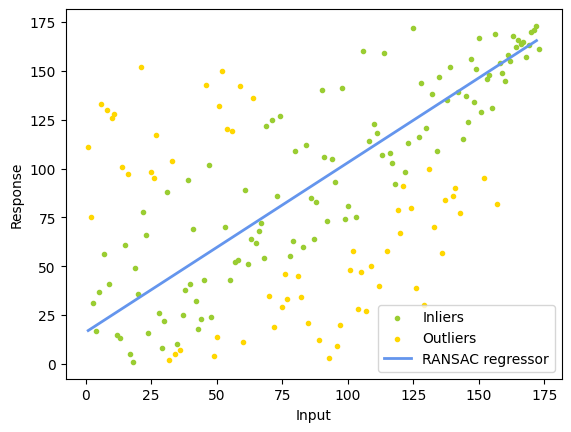

In [46]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model
X,y=corr_df["ranking_target"].values.reshape(-1, 1), corr_df["ranking_prediction"].values.reshape(-1, 1)
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
fit_line_x = np.arange(X.min(), X.max())[:, np.newaxis]
fit_line_y = ransac.predict(fit_line_x)

# Compare estimated coefficients
#print("Estimated coefficients (true, linear regression, RANSAC):")
#print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(
    fit_line_x,
    fit_line_y,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend(loc="lower right")
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

In [47]:
len(fit_line_y)

172

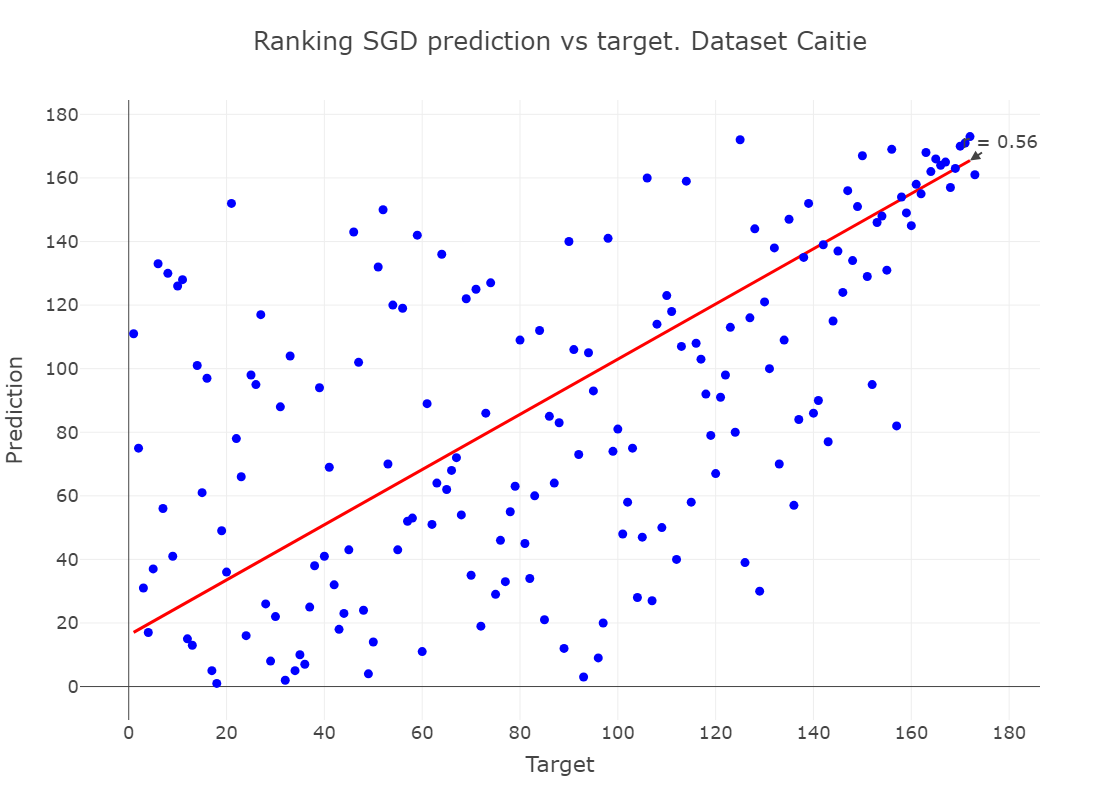

In [48]:
from scipy import stats
import plotly.graph_objs as go
import plotly.express as px
#rg_name="Random Forest"

# Calculate the correlation coefficient
corr_coef,_ = spearmanr(y_pred,y_test)

# Fit a linear regression model
#slope, intercept, r_value, p_value, std_err = stats.linregress(sorted_ranks[rg_name]['target'], sorted_ranks[rg_name]['predict'])

# Generate points for the fit line
#fit_line_x = np.linspace(sorted_ranks[rg_name]['target'].min(), sorted_ranks[rg_name]['target'].max(), 100)
#fit_line_y = slope * fit_line_x + intercept

# Create scatter plot of the data points
scatter = go.Scatter(
    x=corr_df["ranking_target"], 
    y=corr_df["ranking_prediction"], 
    mode='markers', 
    name='Data Points',
    marker=dict(color='blue')
)

# Create fit line plot
fit_line = go.Scatter(
    x=fit_line_x.flatten(), 
    y=fit_line_y.flatten(), 
    mode='lines', 
    name='Fit Line',
    line=dict(color='red')
)

# Create the layout with the fit line equation and correlation coefficient as annotations
layout = go.Layout(
    title=f"Ranking {rg_name} prediction vs target. Dataset {test_dataset}",
    xaxis=dict(title="Target"),
    yaxis=dict(title="Prediction"),
    annotations=[
        dict(
            x=fit_line_x.max(), 
            y=fit_line_y.max(), 
            xref="x", 
            yref="y", 
            text=f"r = {corr_coef:.2f}",
            showarrow=True,
            arrowhead=2,
            ax=30,
            ay=-20
        )
    ],
    width=1200,  # Adjust the width of the figure
    height=800,
    template="presentation",
    showlegend=False 
)

# Combine the scatter plot and fit line
fig = go.Figure(data=[fit_line,scatter], layout=layout)
if add_zcost_features:
    fig.write_image(f"regressors/{test_dataset}/ranking_{rg_name}_simple_zcost.svg",format="SVG")
    fig.write_image(f"regressors/{test_dataset}/ranking_{rg_name}_simple_zcost.png",format="PNG")
else:
    fig.write_image(f"regressors/{test_dataset}/ranking_{rg_name}_simple.svg",format="SVG")
    fig.write_image(f"regressors/{test_dataset}/ranking_{rg_name}_simple.png",format="PNG")
# Show the plot
fig.show()